## problem 1 : 

We consider the BVP

$u''(x) = f(x), \quad u(0)=0,\; u(1)=0,$ with

$$
f(x) = \begin{cases}
1, & 0.4 \le x \le 0.6,\\
0, & \text{otherwise.}
\end{cases}
$$

Using the Green's function $G(x,s)$ for $u''=f$ with zero Dirichlet BCs on $[0,1]$, the exact solution is
$u(x)=\int_{0.4}^{0.6} G(x,s)\,ds$, which simplifies to the following piecewise function:

$$
 u(x) = \begin{cases}
 0.1\,x, & 0 \le x \le 0.4, \\
 -\tfrac{1}{2}x^2 + \tfrac{1}{2}x - 0.08, & 0.4 \le x \le 0.6, \\
 0.1\,(1-x), & 0.6 \le x \le 1.
 \end{cases}
$$

This solution is $C^1$ across the interfaces at $x=0.4,0.6$ and satisfies $u(0)=u(1)=0$ and $u''=f$ piecewise.

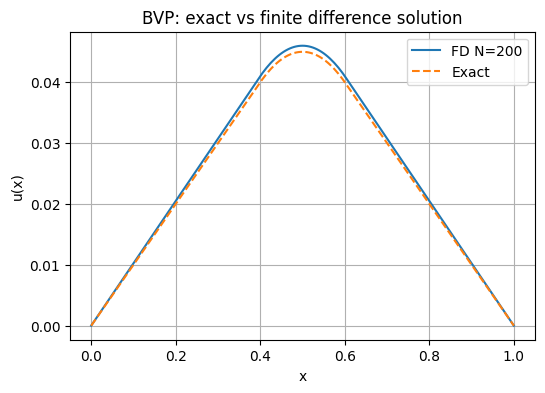

Max error (N=200): 1.000000e-03


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Problem parameters
A, B = 0.4, 0.6

# Exact solution (vectorized)
def u_exact(x):
    x = np.asarray(x)
    u = np.empty_like(x, dtype=float)
    left = (x <= A)
    mid = (x >= A) & (x <= B)
    right = (x >= B)
    u[left] = 0.1 * x[left]
    u[mid] = -0.5 * x[mid]**2 + 0.5 * x[mid] - 0.08
    u[right] = 0.1 * (1.0 - x[right])
    return u

# RHS f(x)
def f_rhs(x):
    x = np.asarray(x)
    return ((x >= A) & (x <= B)).astype(float)

# Thomas algorithm for tridiagonal systems: a (sub), b (diag), c (super), d (rhs)
def thomas(a, b, c, d):
    n = b.size
    cp = np.empty(n-1, dtype=float)
    dp = np.empty(n, dtype=float)

    # Forward elimination
    denom = b[0]
    cp[0] = c[0] / denom
    dp[0] = d[0] / denom
    for i in range(1, n-1):
        denom = b[i] - a[i-1]*cp[i-1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i-1]*dp[i-1]) / denom
    # Handle last row separately (no c at the end)
    denom = b[-1] - a[-1]*cp[-1]
    dp[-1] = (d[-1] - a[-1]*dp[-2]) / denom

    # Back substitution
    x = np.empty(n, dtype=float)
    x[-1] = dp[-1]
    for i in range(n-2, -1, -1):
        x[i] = dp[i] - cp[i]*x[i+1]
    return x

# Finite difference solver using centered differences and Thomas algorithm
def solve_fd(N):
    """Solve u''=f on (0,1) with u(0)=u(1)=0 using N intervals (N+1 grid points)."""
    h = 1.0 / N
    x = np.linspace(0.0, 1.0, N+1)
    xi = x[1:-1]  # interior points

    # Build tridiagonal system: (-1, 2, -1) * u = h^2 * f
    n = N - 1
    a = -np.ones(n-1)
    b = 2.0 * np.ones(n)
    c = -np.ones(n-1)
    d = (h**2) * f_rhs(xi)

    ui = thomas(a, b, c, d)

    # Assemble full solution (including boundaries 0)
    u = np.zeros_like(x)
    u[1:-1] = ui
    return x, u

# Quick smoke test and plot
N = 200
x_num, u_num = solve_fd(N)
u_ex = u_exact(x_num)

plt.figure(figsize=(6,4))
plt.plot(x_num, u_num, label=f'FD N={N}')
plt.plot(x_num, u_ex, '--', label='Exact')
plt.xlabel('x'); plt.ylabel('u(x)')
plt.title('BVP: exact vs finite difference solution')
plt.legend(); plt.grid(True)
plt.show()

# Report max error
max_err = np.max(np.abs(u_num - u_ex))
print(f'Max error (N={N}): {max_err:.6e}')

N=  20, h=5.000e-02, max error=2.000000e-03
N=  40, h=2.500e-02, max error=1.000000e-03
N=  80, h=1.250e-02, max error=5.000000e-04
N= 160, h=6.250e-03, max error=2.500000e-04
N= 320, h=3.125e-03, max error=1.250000e-04
Observed order (slope): ~ 1.00


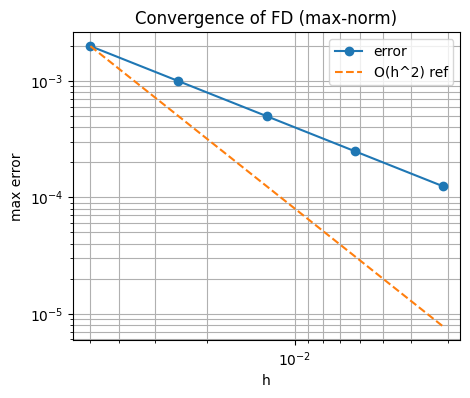

In [8]:
# Convergence study (max-norm error and observed order)
Ns = [20, 40, 80, 160, 320]
errs = []
hs = []
for N in Ns:
    x_num, u_num = solve_fd(N)
    u_ex = u_exact(x_num)
    err = np.max(np.abs(u_num - u_ex))
    errs.append(err)
    hs.append(1.0/N)

hs = np.array(hs)
errs = np.array(errs)

# Fit slope on log-log to estimate order: err ~ C h^p => slope = p
p = np.polyfit(np.log(hs), np.log(errs+1e-300), 1)
order = p[0]

for N, h, e in zip(Ns, hs, errs):
    print(f'N={N:4d}, h={h:.3e}, max error={e:.6e}')
print(f"Observed order (slope): ~ {order:.2f}")

plt.figure(figsize=(5,4))
plt.loglog(hs, errs, 'o-', label='error')
plt.loglog(hs, errs[0]*(hs/hs[0])**2, '--', label='O(h^2) ref')
plt.gca().invert_xaxis()
plt.xlabel('h')
plt.ylabel('max error')
plt.title('Convergence of FD (max-norm)')
plt.grid(True, which='both')
plt.legend()
plt.show()

## Problem 2:

We solve

$u'' - 2u' + u = 1, \quad u(0)=0, \quad u'(1)=1$.

Homogeneous problem: $w'' - 2w' + w = 0$ has characteristic $(r-1)^2=0$ giving $w(x) = (A + Bx)e^{x}$. Imposing $w(0)=0 \Rightarrow A=0$, and $w'(x)=(B + Bx)e^{x}$ so $w'(1)=2Be=0 \Rightarrow B=0$. Thus $w\equiv 0$. Uniqueness follows: any two solutions differ by a homogeneous solution that must be zero.

Exact solution: Seek $u(x)=1 + (C_1 + C_2 x)e^{x}$ (particular $=1$). Apply $u(0)=0 \Rightarrow 1 + C_1 =0 \Rightarrow C_1=-1$. Derivative: $u'(x)=(C_2 + C_1 + C_2 x)e^{x}$. So $u'(1)=(2C_2 -1)e =1 \Rightarrow 2C_2 -1 = e^{-1} \Rightarrow C_2 = \tfrac{1 + e^{-1}}{2}$. Therefore

$$u(x) = 1 + \Big(-1 + \tfrac{1+e^{-1}}{2} x\Big)e^{x}.$$

We develop a 2nd-order finite difference scheme with grid $x_i=i h$, $h=1/N$, unknowns $u_i \approx u(x_i)$.
- Dirichlet: $u_0=0$ prescribed.
- Interior equation (central differences):
  $$\frac{u_{i+1}-2u_i+u_{i-1}}{h^2} - 2\frac{u_{i+1}-u_{i-1}}{2h} + u_i = 1, \quad i=1,\dots,N-1.$$
  Which simplifies to $ (1/h^2 - 1/h)u_{i+1} + (-2/h^2 + 1)u_i + (1/h^2 + 1/h)u_{i-1} = 1$.
- Neumann at $x=1$: 2nd-order backward derivative $u'(1) \approx (3u_N - 4u_{N-1} + u_{N-2})/(2h)=1$.

Unknowns: $u_1,\dots,u_N$. This yields an $N\times N$ linear system.


Problem2: N=200 max error=1.412190e-05


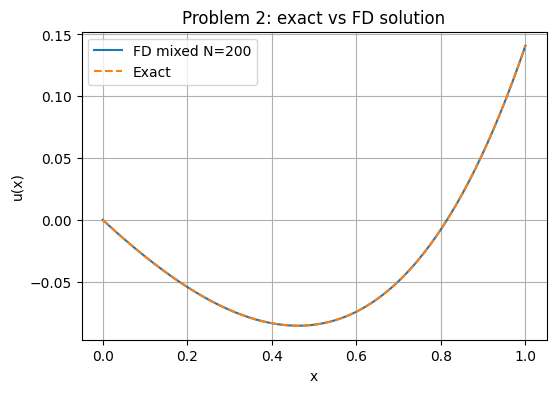

In [9]:
# Finite difference solver for Problem 2
import numpy as np
import matplotlib.pyplot as plt

def u_exact_p2(x):
    x = np.asarray(x)
    C2 = (1 + np.exp(-1.0))/2.0
    return 1.0 + (-1.0 + C2 * x) * np.exp(x)

def solve_fd_mixed(N):
    """Solve u'' - 2u' + u = 1, u(0)=0, u'(1)=1 with 2nd-order FD.
    N intervals, h=1/N, grid points x_i=i h. Unknowns u_1..u_N.
    Returns full grid x (size N+1) and solution array u of length N+1.
    """
    h = 1.0 / N
    x = np.linspace(0.0, 1.0, N+1)
    n = N  # number of unknowns (u_1..u_N)
    A = np.zeros((n, n))
    b = np.ones(n)  # RHS interior is 1; last row replaced for Neumann

    # Fill interior equations i=1..N-1 corresponds to row i-1
    for i in range(1, N):
        row = i - 1
        # coefficients: (1/h^2 - 1/h) u_{i+1} + (-2/h^2 + 1) u_i + (1/h^2 + 1/h) u_{i-1} = 1
        # Map to unknown indices: u_{i-1} -> i-2, u_i -> i-1, u_{i+1} -> i
        # Handle i=1 (u_{i-1}=u_0 known=0): drop term and adjust RHS
        coeff_im1 = (1.0/h**2 + 1.0/h)
        coeff_i   = (-2.0/h**2 + 1.0)
        coeff_ip1 = (1.0/h**2 - 1.0/h)
        if i == 1:
            # u_0 term known =0, so skip adding coefficient_im1
            A[row, row] = coeff_i
            A[row, row+1] = coeff_ip1
        else:
            A[row, row-1] = coeff_im1
            A[row, row]   = coeff_i
            if i < N-1:
                A[row, row+1] = coeff_ip1
            else:
                # i = N-1 adds u_{N} coefficient
                A[row, row+1] = coeff_ip1
        b[row] = 1.0  # interior RHS

    # Neumann boundary equation row N-1: (3u_N -4u_{N-1} + u_{N-2})/(2h)=1
    # Unknown indices: u_{N-2} -> N-3, u_{N-1} -> N-2, u_N -> N-1
    A[-1, -3] = 1.0/(2*h)
    A[-1, -2] = -4.0/(2*h)
    A[-1, -1] = 3.0/(2*h)
    b[-1] = 1.0

    # Solve system
    u_unknown = np.linalg.solve(A, b)
    u = np.zeros(N+1)
    u[1:] = u_unknown
    return x, u

# Test single N and plot
N_test = 200
x_p2, u_p2 = solve_fd_mixed(N_test)
u_ex_p2 = u_exact_p2(x_p2)
err_p2 = np.max(np.abs(u_p2 - u_ex_p2))
print(f"Problem2: N={N_test} max error={err_p2:.6e}")
plt.figure(figsize=(6,4))
plt.plot(x_p2, u_p2, label=f'FD mixed N={N_test}')
plt.plot(x_p2, u_ex_p2, '--', label='Exact')
plt.xlabel('x'); plt.ylabel('u(x)')
plt.title('Problem 2: exact vs FD solution')
plt.legend(); plt.grid(True)
plt.show()

N=  25 h=4.000e-02 max_err=8.611e-04
N=  50 h=2.000e-02 max_err=2.212e-04
N= 100 h=1.000e-02 max_err=5.609e-05
N= 200 h=5.000e-03 max_err=1.412e-05
N= 400 h=2.500e-03 max_err=3.543e-06
Observed order ~ 1.98


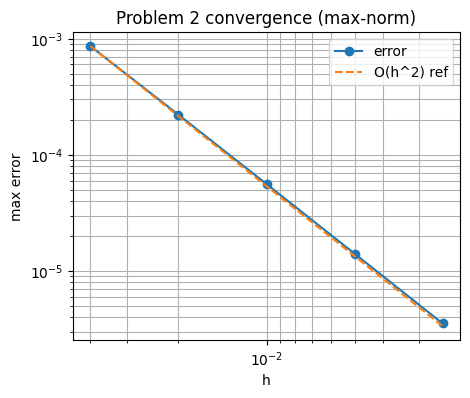

In [10]:
# Convergence study for Problem 2
Ns = [25, 50, 100, 200, 400]
errs = []
hs = []
for N in Ns:
    x_p2, u_p2 = solve_fd_mixed(N)
    u_ex_p2 = u_exact_p2(x_p2)
    err = np.max(np.abs(u_p2 - u_ex_p2))
    errs.append(err)
    hs.append(1.0/N)

hs = np.array(hs)
errs = np.array(errs)
# Fit observed order
p = np.polyfit(np.log(hs), np.log(errs+1e-300), 1)
order = p[0]
for N,h,e in zip(Ns, hs, errs):
    print(f"N={N:4d} h={h:.3e} max_err={e:.3e}")
print(f"Observed order ~ {order:.2f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.loglog(hs, errs, 'o-', label='error')
plt.loglog(hs, errs[0]*(hs/hs[0])**2, '--', label='O(h^2) ref')
plt.gca().invert_xaxis()
plt.xlabel('h'); plt.ylabel('max error')
plt.title('Problem 2 convergence (max-norm)')
plt.grid(True, which='both')
plt.legend();
plt.show()

## Problem 3: Neumann–Neumann Poisson problem and discretization details
We solve

$$u''(x) = \sin(2\pi x),\quad u'(0)=0,\quad u'(1)=0.$$

### Solvability (Consistency Condition)
For pure Neumann problems on [0,1], a solution exists iff
$$\int_0^1 f(x)\,dx = 0.$$
Here $f(x)=\sin(2\pi x)$ and
$$\int_0^1 \sin(2\pi x)\,dx = \Big[-\frac{\cos(2\pi x)}{2\pi}\Big]_0^1 = 0,$$
so the consistency condition is satisfied and at least one solution exists.

### Exact Solution Family
Integrate:
$$u'(x) = -\frac{1}{2\pi}\cos(2\pi x) + C_1.$$
Apply $u'(0)=0$: $-\tfrac{1}{2\pi}\cos 0 + C_1 = 0 \Rightarrow C_1=\tfrac{1}{2\pi}$. Then
$$u'(x) = -\frac{1}{2\pi}\cos(2\pi x) + \frac{1}{2\pi}.$$
Integrate again:
$$u(x) = -\frac{1}{4\pi^2}\sin(2\pi x) + \frac{x}{2\pi} + C_2,$$
with arbitrary constant $C_2$. We take the base solution with $C_2=0$ and adjust later.

### Finite Difference Discretization
Let grid points $x_i = i h$, $i=0,\dots,N$, $h=1/N$. Denote $u_i \approx u(x_i)$.
Interior second derivative (standard central difference, second order):
$$u''(x_i) \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2}, \quad i=1,\dots,N-1.$$
RHS: $f(x_i)=\sin(2\pi x_i)$.
We enforce $u'(0)=0$ using the central difference formula
$$u'(0) \approx \frac{u_1 - u_{-1}}{2h}=0 \Rightarrow u_{-1}=u_1.$$
Substitute into the second derivative at $x_0$:
$$u''(0) \approx \frac{u_1 - 2u_0 + u_{-1}}{h^2} = \frac{u_1 - 2u_0 + u_1}{h^2} = \frac{2(u_1 - u_0)}{h^2}.$$
Similarly at $x_N$: $u'(1)=0$ gives $u_{N+1}=u_{N-1}$ and
$$u''(1) \approx \frac{u_{N-1} - 2u_N + u_{N+1}}{h^2} = \frac{u_{N-1} - 2u_N + u_{N-1}}{h^2} = \frac{2(u_{N-1} - u_N)}{h^2}.$$
Each is second-order accurate because the central derivative plus ghost-point reflection preserves symmetry and cancels $O(h)$ terms.



P3 central Neumann: N=200 max error (shifted) = 6.545092e-06


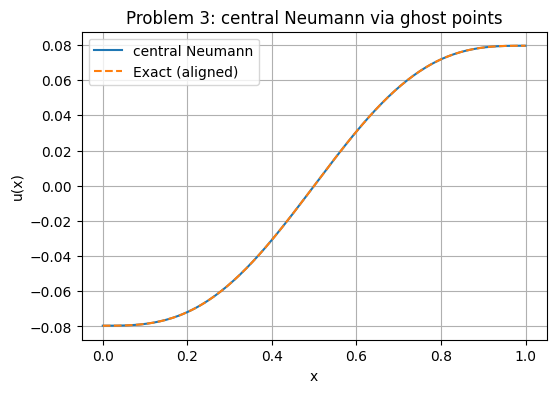

In [11]:

def u_exact_p3_base(x):
    x = np.asarray(x)
    return -np.sin(2*np.pi*x)/(4*np.pi**2) + x/(2*np.pi)

# Constant alignment utility (trapezoidal weights)
def align_constant(u_num, u_base):
    w = np.ones_like(u_num)
    w[0] = 0.5; w[-1] = 0.5
    return np.sum(w*(u_num - u_base))/np.sum(w)

def solve_fd_p3(N):
    """Central-difference Neumann BCs using ghost-point elimination:
    u_{-1}=u_1, u_{N+1}=u_{N-1}. Apply u''=f at i=0..N with modified end rows.
    Returns grid x and solution u (minimal-norm via least squares).
    """
    h = 1.0 / N
    x = np.linspace(0.0, 1.0, N+1)
    m = N + 1
    A = np.zeros((m, m))
    b = np.sin(2*np.pi*x)

    invh2 = 1.0/h**2
    # i=0 row: 2(u1 - u0)/h^2 = f0 -> (-2)u0 + (2)u1
    A[0, 0] = -2*invh2
    A[0, 1] =  2*invh2
    # interior 1..N-1
    for i in range(1, N):
        A[i, i-1] =  invh2
        A[i, i]   = -2*invh2
        A[i, i+1] =  invh2
    # i=N row: 2(u_{N-1} - u_N)/h^2 = fN -> (2)u_{N-1} + (-2)u_N
    A[N, N-1] =  2*invh2
    A[N, N]   = -2*invh2

    # Solve least squares to handle the constant nullspace
    u, *_ = np.linalg.lstsq(A, b, rcond=None)
    return x, u

# Quick comparison vs earlier solver
N = 200
x_c, u_c = solve_fd_p3(N)
uex_base = u_exact_p3_base(x_c)
Copt = align_constant(u_c, uex_base)
uex = uex_base + Copt
err_c = np.max(np.abs(u_c - uex))
print(f"P3 central Neumann: N={N} max error (shifted) = {err_c:.6e}")

plt.figure(figsize=(6,4))
plt.plot(x_c, u_c, label='central Neumann')
plt.plot(x_c, uex, '--', label='Exact (aligned)')
plt.xlabel('x'); plt.ylabel('u(x)')
plt.title('Problem 3: central Neumann via ghost points')
plt.legend(); plt.grid(True)
plt.show()

N=  25 h=4.000e-02 max_err=4.193e-04
N=  50 h=2.000e-02 max_err=1.047e-04
N= 100 h=1.000e-02 max_err=2.618e-05
N= 200 h=5.000e-03 max_err=6.545e-06
N= 400 h=2.500e-03 max_err=1.636e-06
Observed order ~ 2.00


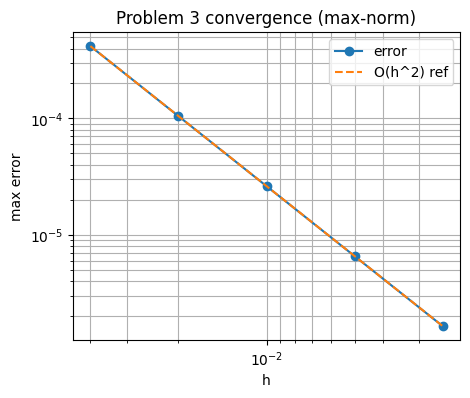

In [12]:
# Convergence study for Problem 3
Ns = [25, 50, 100, 200, 400]
errs = []
hs = []
for N in Ns:
    x3, u3 = solve_fd_p3(N)
    uex3_base = u_exact_p3_base(x3)
    Copt = align_constant(u3, uex3_base)
    uex3 = uex3_base + Copt
    err = np.max(np.abs(u3 - uex3))
    errs.append(err)
    hs.append(1.0/N)

hs = np.array(hs)
errs = np.array(errs)
# Observed order
p = np.polyfit(np.log(hs), np.log(errs+1e-300), 1)
order = p[0]
for N,h,e in zip(Ns, hs, errs):
    print(f"N={N:4d} h={h:.3e} max_err={e:.3e}")
print(f"Observed order ~ {order:.2f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.loglog(hs, errs, 'o-', label='error')
plt.loglog(hs, errs[0]*(hs/hs[0])**2, '--', label='O(h^2) ref')
plt.gca().invert_xaxis()
plt.xlabel('h'); plt.ylabel('max error')
plt.title('Problem 3 convergence (max-norm)')
plt.grid(True, which='both')
plt.legend()
plt.show()

## Problem 4:
We consider
$$u''(x)=e^{\sin x},\quad u'(0)=0,\quad u'(1)=\alpha.$$
Solvability condition (integrate the ODE from 0 to 1):
$$u'(1)-u'(0)=\int_0^1 e^{\sin t}\,dt \;\Rightarrow\; \alpha = \int_0^1 e^{\sin t}\,dt.$$
Thus a solution exists iff $\alpha$ equals this integral. Because the operator and derivative boundary conditions annihilate constants, solutions are unique up to an additive constant.

Construct a solution: Integrate once with $C_1=0$ (due to $u'(0)=0$):
$$u'(x)=\int_0^x e^{\sin t}\,dt.$$
Integrate again:
$$u(x)=\int_0^x \left( \int_0^s e^{\sin t}\,dt \right) ds + C_2 = \int_0^x (x-t) e^{\sin t}\,dt + C_2.$$
We can choose $C_2=0$ (setting $u(0)=0$) to produce one representative solution; any other solution differs by a constant.

Below we approximate $\alpha$ numerically and evaluate the solution $u(x)$ by quadrature.



Problem4 FD (correct BC): N=200 max error (after constant shift) = 1.760689e-07
u'(1) discrete approx (I1[-1]) ≈ 1.631870136298, alpha ≈ 1.631869608418, diff=5.279e-07


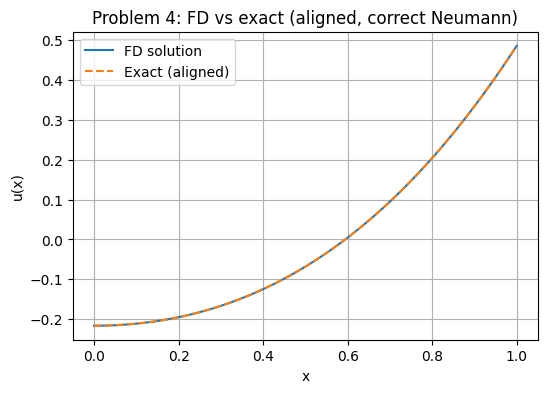

N=  25 h=4.000e-02 max_err=1.132e-05
N=  50 h=2.000e-02 max_err=2.822e-06
N= 100 h=1.000e-02 max_err=7.047e-07
N= 200 h=5.000e-03 max_err=1.761e-07
N= 400 h=2.500e-03 max_err=4.400e-08
Observed order ~ 2.00


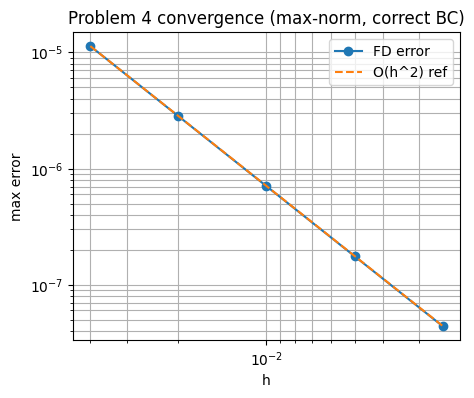

In [13]:
# Finite difference method for Problem 4 and convergence comparison (correct non-zero Neumann at x=1)
import numpy as np
import matplotlib.pyplot as plt

# f(x) = e^{sin x}
def f_p4(x):
    return np.exp(np.sin(x))

# High-accuracy alpha = ∫_0^1 f(x) dx (reuse Simpson from earlier if available)
try:
    # If simpson already defined
    alpha_p4 = simpson(f_p4, 0.0, 1.0, 4000)
except NameError:
    def simpson(f, a, b, N):
        if N % 2 == 1:
            N += 1
        x = np.linspace(a, b, N+1)
        h = (b - a)/N
        y = f(x)
        S = y[0] + y[-1] + 4*np.sum(y[1:-1:2]) + 2*np.sum(y[2:-2:2])
        return S*h/3
    alpha_p4 = simpson(f_p4, 0.0, 1.0, 4000)

# Exact base solution on grid (u(0)=0 representative)
def exact_base_on_grid(x):
    fvals = f_p4(x)
    hseg = np.diff(x)
    I1 = np.zeros_like(x)
    I2 = np.zeros_like(x)
    for i in range(1, len(x)):
        dt = hseg[i-1]
        I1[i] = I1[i-1] + 0.5*(fvals[i-1] + fvals[i])*dt
        I2[i] = I2[i-1] + 0.5*(x[i-1]*fvals[i-1] + x[i]*fvals[i])*dt
    u_base = x*I1 - I2
    return u_base, I1

# Align constant using trapezoidal weights
def align_const(u_num, u_base):
    n = len(u_num)
    w = np.ones(n); w[0] = 0.5; w[-1] = 0.5
    C = np.sum(w*(u_num - u_base)) / np.sum(w)
    return C

# Ghost-point Neumann FD solver with u'(0)=0, u'(1)=alpha
# Using ghost relations: u_{-1} = u_1 (from u'(0)=0), u_{N+1} = u_{N-1} + 2h alpha (from u'(1)=alpha)
# Second derivative at boundaries: (u1 -2u0 + u_{-1})/h^2 = f0, (u_{N-1} -2u_N + u_{N+1})/h^2 = fN
# Right boundary equation becomes: (-2/h^2)u_N + (2/h^2)u_{N-1} = f_N - (2 alpha)/h

def solve_fd_p4(N, alpha):
    h = 1.0 / N
    x = np.linspace(0.0, 1.0, N+1)
    m = N + 1
    A = np.zeros((m, m))
    b = f_p4(x).copy()
    invh2 = 1.0 / h**2
    # Left boundary row i=0
    A[0,0] = -2*invh2
    A[0,1] =  2*invh2
    # Interior rows
    for i in range(1, N):
        A[i,i-1] =  invh2
        A[i,i]   = -2*invh2
        A[i,i+1] =  invh2
    # Right boundary row i=N
    A[N,N]   = -2*invh2
    A[N,N-1] =  2*invh2
    b[N] = b[N] - (2*alpha)/h  # adjust RHS for non-zero derivative at x=1
    # Least squares solve (singular matrix) then constant alignment
    u, *_ = np.linalg.lstsq(A, b, rcond=None)
    return x, u

# Single run comparison
N_test = 200
x_fd, u_fd = solve_fd_p4(N_test, alpha_p4)
u_base, I1 = exact_base_on_grid(x_fd)
Copt = align_const(u_fd, u_base)
u_ex = u_base + Copt
err = np.max(np.abs(u_fd - u_ex))
print(f"Problem4 FD (correct BC): N={N_test} max error (after constant shift) = {err:.6e}")
print(f"u'(1) discrete approx (I1[-1]) ≈ {I1[-1]:.12f}, alpha ≈ {alpha_p4:.12f}, diff={I1[-1]-alpha_p4:.3e}")

plt.figure(figsize=(6,4))
plt.plot(x_fd, u_fd, label='FD solution')
plt.plot(x_fd, u_ex, '--', label='Exact (aligned)')
plt.xlabel('x'); plt.ylabel('u(x)')
plt.title('Problem 4: FD vs exact (aligned, correct Neumann)')
plt.legend(); plt.grid(True)
plt.show()

# Convergence study
Ns = [25, 50, 100, 200, 400]
errs = []; hs=[]
for N in Ns:
    xg, ug = solve_fd_p4(N, alpha_p4)
    ub, _ = exact_base_on_grid(xg)
    Cg = align_const(ug, ub)
    ue = ub + Cg
    errs.append(np.max(np.abs(ug - ue)))
    hs.append(1.0/N)

hs = np.array(hs); errs = np.array(errs)
p = np.polyfit(np.log(hs), np.log(errs+1e-300), 1)
order = p[0]
for N,h,e in zip(Ns, hs, errs):
    print(f"N={N:4d} h={h:.3e} max_err={e:.3e}")
print(f"Observed order ~ {order:.2f}")

plt.figure(figsize=(5,4))
plt.loglog(hs, errs, 'o-', label='FD error')
plt.loglog(hs, errs[0]*(hs/hs[0])**2, '--', label='O(h^2) ref')
plt.gca().invert_xaxis()
plt.xlabel('h'); plt.ylabel('max error')
plt.title('Problem 4 convergence (max-norm, correct BC)')
plt.grid(True, which='both')
plt.legend()
plt.show()



## Problem 5:
We now solve
$$\varepsilon u''(x) + (1+\varepsilon) u'(x) + u(x) = 0, \quad u(0)=0,\; u(1)=1,$$
with $\varepsilon = 0.01$.

### Exact Solution
The characteristic equation is
$$\varepsilon r^2 + (1+\varepsilon) r + 1 = 0.$$
For $\varepsilon=0.01$ this is $0.01 r^2 + 1.01 r + 1=0$ with discriminant $\Delta = 1.01^2 - 4(0.01)(1) = 0.9801$, so $\sqrt{\Delta}=0.99$ and
$$r_{1,2} = \frac{-1.01 \pm 0.99}{2\cdot 0.01} = -1,\; -100.$$
Thus
$$u(x) = A e^{-x} + B e^{-100 x}.$$
Imposing $u(0)=0$ gives $A + B = 0 \Rightarrow B = -A$. Imposing $u(1)=1$ gives
$$A (e^{-1} - e^{-100}) = 1 \Rightarrow A = \frac{1}{e^{-1} - e^{-100}}.$$
Therefore the exact solution (taking $B=-A$) is
$$u(x) = \frac{e^{-x} - e^{-100 x}}{e^{-1} - e^{-100}}.$$
Because $e^{-100}\ll 1$, $A \approx e$, and the solution exhibits a thin boundary layer near $x=0$ of width $O(1/100) = O(\varepsilon)$ governed by the fast-decaying $e^{-100 x}$ term.

### Finite Difference Scheme
On a uniform grid $x_i = i h$, $i=0,\dots,N$, $h=1/N$, approximate derivatives at interior points with second-order centered differences:
$$u'(x_i) \approx \frac{u_{i+1}-u_{i-1}}{2h}, \quad u''(x_i) \approx \frac{u_{i+1}-2u_i+u_{i-1}}{h^2}.$$
The interior equation becomes
$$\varepsilon \frac{u_{i+1}-2u_i+u_{i-1}}{h^2} + (1+\varepsilon) \frac{u_{i+1}-u_{i-1}}{2h} + u_i = 0.$$
Boundary values: $u_0=0$, $u_N=1$ are imposed directly. This yields a tridiagonal linear system for $u_1,\dots,u_{N-1}$.

### Resolution Considerations
To resolve the boundary layer associated with the $e^{-100 x}$ term, we need $h \ll 1/100$. Grids with $N \ge 1000$ (i.e. $h \le 10^{-3}$) begin to capture the layer sharply. We perform a convergence study for increasing $N$ and compare against the exact solution.

Problem5 single run: N=2000 max error=2.146e-04


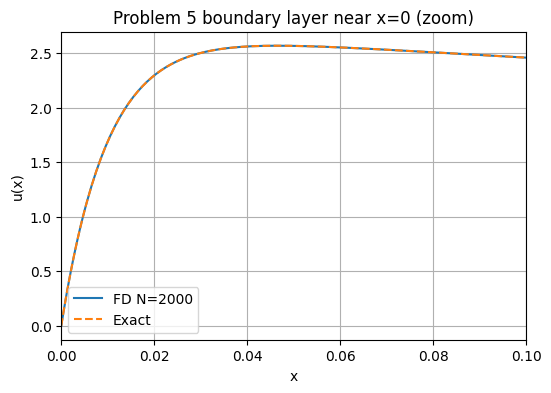

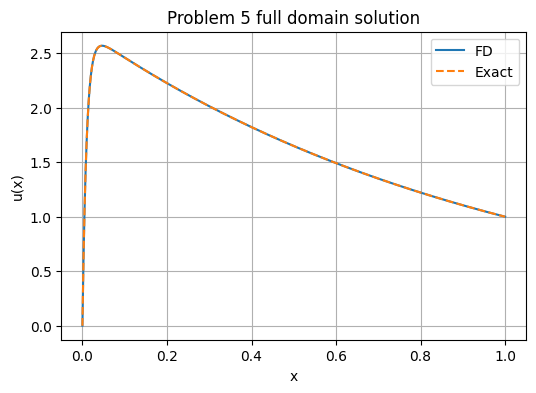

N=  50 h=2.000e-02 max_err=3.815e-01
N= 100 h=1.000e-02 max_err=9.693e-02
N= 200 h=5.000e-03 max_err=2.207e-02
N= 400 h=2.500e-03 max_err=5.402e-03
N= 800 h=1.250e-03 max_err=1.343e-03
N=1600 h=6.250e-04 max_err=3.354e-04
Observed order (fine-grid fit) ~ 2.01


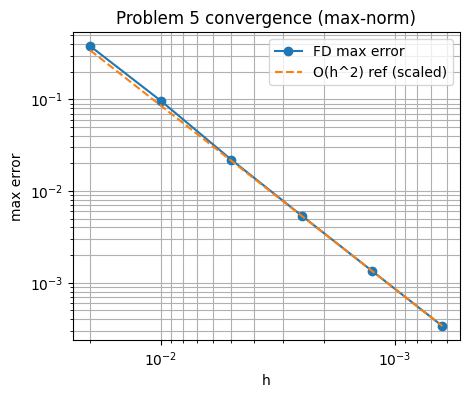

In [14]:

def exact_p5(x, eps=0.01):
    # Solve quadratic for roots robustly
    a = eps
    b = 1 + eps
    c = 1.0
    disc = b*b - 4*a*c
    r1 = (-b + np.sqrt(disc)) / (2*a)
    r2 = (-b - np.sqrt(disc)) / (2*a)
    # Enforce ordering: r2 more negative
    # Use BCs: A e^{r1 x} + B e^{r2 x}
    # u(0)=0 => A + B =0 => B=-A
    # u(1)=1 => A(e^{r1} - e^{r2})=1 => A = 1/(e^{r1} - e^{r2})
    A = 1.0/(np.exp(r1) - np.exp(r2))
    return A*(np.exp(r1*x) - np.exp(r2*x))

# Centered FD solver (tridiagonal) for Problem 5

def solve_fd_p5(N, eps=0.01):
    h = 1.0 / N
    x = np.linspace(0.0, 1.0, N+1)
    n = N-1  # interior unknowns u_1..u_{N-1}
    a = np.zeros(n-1)
    b = np.zeros(n)
    c = np.zeros(n-1)
    rhs = np.zeros(n)
    # Coefficients from: eps*(u_{i+1}-2u_i+u_{i-1})/h^2 + (1+eps)*(u_{i+1}-u_{i-1})/(2h) + u_i = 0
    # Rearranged: [eps/h^2 + (1+eps)/(2h)] u_{i+1} + [ -2eps/h^2 + 1 ] u_i + [ eps/h^2 - (1+eps)/(2h) ] u_{i-1} = 0
    alpha = eps/h**2 + (1+eps)/(2*h)
    beta  = -2*eps/h**2 + 1.0
    gamma = eps/h**2 - (1+eps)/(2*h)
    for i in range(n):
        # interior indices correspond to grid point i+1
        b[i] = beta
        if i < n-1:
            c[i] = alpha
        if i > 0:
            a[i-1] = gamma
    # Adjust first equation for known u_0=0 (term gamma*u_0 drops)
    # Adjust last equation for known u_N=1: add alpha*1 to RHS
    rhs[-1] = -alpha  # because we move alpha*u_N to RHS (equation sum =0)
    # Solve tridiagonal via Thomas
    # Forward elimination
    cp = np.empty(n-1)
    dp = np.empty(n)
    denom = b[0]
    cp[0] = c[0]/denom
    dp[0] = rhs[0]/denom
    for i in range(1, n-1):
        denom = b[i] - a[i-1]*cp[i-1]
        cp[i] = c[i]/denom
        dp[i] = (rhs[i] - a[i-1]*dp[i-1])/denom
    # last row
    denom = b[-1] - a[-1]*cp[-1] if n>1 else b[-1]
    dp[-1] = (rhs[-1] - (a[-1]*dp[-2] if n>1 else 0.0))/denom
    # Back substitution
    u_int = np.empty(n)
    u_int[-1] = dp[-1]
    for i in range(n-2, -1, -1):
        u_int[i] = dp[i] - cp[i]*u_int[i+1]
    u = np.zeros(N+1)
    u[0] = 0.0
    u[-1] = 1.0
    u[1:-1] = u_int
    return x, u

# Single high-resolution comparison
N_high = 2000
x5, u5 = solve_fd_p5(N_high)
uex5 = exact_p5(x5)
err5 = np.max(np.abs(u5 - uex5))
print(f"Problem5 single run: N={N_high} max error={err5:.3e}")

plt.figure(figsize=(6,4))
plt.plot(x5, u5, label=f'FD N={N_high}')
plt.plot(x5, uex5, '--', label='Exact')
plt.xlim(0,0.1)  # zoom near boundary layer
plt.xlabel('x'); plt.ylabel('u(x)')
plt.title('Problem 5 boundary layer near x=0 (zoom)')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(x5, u5, label='FD')
plt.plot(x5, uex5, '--', label='Exact')
plt.xlabel('x'); plt.ylabel('u(x)')
plt.title('Problem 5 full domain solution')
plt.legend(); plt.grid(True)
plt.show()

# Convergence study (ensure h resolves layer: include large N values)
Ns = [50, 100, 200, 400, 800, 1600]
errs = []
hs = []
for N in Ns:
    xg, ug = solve_fd_p5(N)
    uexg = exact_p5(xg)
    errs.append(np.max(np.abs(ug - uexg)))
    hs.append(1.0/N)

hs = np.array(hs); errs = np.array(errs)
p = np.polyfit(np.log(hs[-4:]), np.log(errs[-4:]+1e-300), 1)  # fit on finest four to avoid pre-asymptotic
order = p[0]
for N,h,e in zip(Ns, hs, errs):
    print(f"N={N:4d} h={h:.3e} max_err={e:.3e}")
print(f"Observed order (fine-grid fit) ~ {order:.2f}")

plt.figure(figsize=(5,4))
plt.loglog(hs, errs, 'o-', label='FD max error')
plt.loglog(hs, errs[-1]*(hs/hs[-1])**2, '--', label='O(h^2) ref (scaled)')
plt.gca().invert_xaxis()
plt.xlabel('h'); plt.ylabel('max error')
plt.title('Problem 5 convergence (max-norm)')
plt.grid(True, which='both')
plt.legend(); plt.show()